# Customer Churn em uma Operador de Telecom

# 1.0 Problema de Negócio

Customer Churn (ou Rotatividade de Clientes, em uma tradução livre) refere-se a uma decisão tomada pelo cliente sobre o término do relacionamento comercial. Refere-se também à perda de clientes. A fidelidade do cliente e a rotatividade de clientes sempre somam 100%. Se uma empresa tem uma taxa de fidelidade de 60%, então a taxa de perda de clientes é de 40%. De acordo com a regra de lucratividade do cliente 80/20, 20% dos clientes estão gerando 80% da receita. Portanto, é muito importante prever os usuários que provavelmente abandonarão o relacionamento comercial e os fatores que afetam as decisões do cliente.

Neste projeto, vamos prever o Customer Churn em uma Operadora de Telecom.

O objetivo desse projeto é criar um modelo de aprendizagem de máquina que possa prever se um cliente pode ou não cancelar seu plano e qual a probabilidade de isso ocorrer.

# 2.0 Módulos Utilizados

In [1]:
# manipulação de dados
import pandas as pd
import numpy  as np

# visualização
import matplotlib.pyplot as plt
import seaborn           as sns

# warnings
import warnings
warnings.filterwarnings('ignore')

# algoritmos de ml
from sklearn.ensemble              import RandomForestClassifier
from sklearn.linear_model          import LogisticRegression
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.svm                   import SVC
from xgboost                       import XGBClassifier

# data split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# pré-processamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

# ajuste fino
from sklearn.model_selection import RandomizedSearchCV

# metricas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# 3.0 Funções Auxiliares

In [2]:
# função para imprimir as principais estatísticas
def stats(cols):
    return train[cols].describe()
    
# função para imprimir boxplot
def box(cols):
    train[cols].plot(kind = 'box', figsize = (10, 6))
    plt.show()
    
# função para imprimir histogramas
def histPlot(cols):
    plt.figure(figsize = (15, 6))

    for i in range(0, len(cols)):
    
        plt.subplot(1, len(cols), (i + 1))
        sns.histplot(train, x = cols[i], hue = 'churn')

    plt.show()
    
# função para imprimir as estatísticas separadas pelo churn
def stats_churn(cols):
    churn_situation = ['yes', 'no']
    df              = pd.DataFrame()

    for col in cols:
    
        for churn in churn_situation:
        
            stats         = train[train['churn'] == churn][col]
            stats         = pd.DataFrame(stats.describe())
            stats.columns = [col + '_churn_' + churn]
            df            = pd.concat([df, stats], axis = 1)
        
    return df

# fuções para normalização e padronização
def min_max_scaler(x):
    norm = MinMaxScaler()
    return norm.fit_transform(x)

def normalizer(x):
    norm = Normalizer().fit(x)
    return norm.transform(x)

def standard_scaler(x):
    norm = StandardScaler().fit(x)
    return norm.transform(x)

# função para realizar o treinamento dos modelos
def fitting(models, x, y):
    
    # dataframes para salvar os resultados
    result = pd.DataFrame()
    stats  = pd.DataFrame()
    
    # split dos dados
    kfold  = KFold(n_splits = 5, shuffle = True, random_state = 0)
    
    # loop para treinar cada modelo
    for name, model in models:
        
        acc          = cross_val_score(model, x, y, cv = kfold, scoring = 'accuracy')
        
        result[name] = acc
    
        mean         = round((100 * acc.mean()), 3)
        
        std          = round(acc.std(), 5)
        
        stats[name]  = [mean, std]
    
    stats.index      = ['mean', 'std']
    
    # boxplot do resultado
    result.plot(kind = 'box', figsize = (15, 8))
    plt.show()
    
    # retornar as acurácias de cada modelo treinado
    return stats

# 4.0 Análise Exploratória dos Dados

Em estatística, a análise exploratória de dados (AED) é uma abordagem à análise de conjuntos de dados de modo a resumir suas características principais, frequentemente com métodos visuais. Um modelo estatístico pode ou não ser usado, mas primariamente a AED tem como objetivo observar o que os dados podem nos dizer além da modelagem formal ou do processo de teste de hipóteses. 

A análise exploratória de dados emprega grande variedade de técnicas gráficas e quantitativas, visando maximizar a obtenção de informações ocultas na sua estrutura, descobrir variáveis importantes em suas tendências, detectar comportamentos anômalos do fenômeno, testar se são válidas as hipóteses assumidas, escolher modelos e determinar o número ótimo de variáveis.

## 4.1 Reconhecimento dos Dados

In [3]:
# import dos dados de treino
train = pd.read_csv('projeto4_telecom_treino.csv')
train.head()

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [4]:
# import dos dados de teste
test = pd.read_csv('projeto4_telecom_teste.csv')
test.head()

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,HI,101,area_code_510,no,no,0,70.9,123,12.05,...,73,18.01,236.0,73,10.62,10.6,3,2.86,3,no
1,2,MT,137,area_code_510,no,no,0,223.6,86,38.01,...,139,20.81,94.2,81,4.24,9.5,7,2.57,0,no
2,3,OH,103,area_code_408,no,yes,29,294.7,95,50.10,...,105,20.17,300.3,127,13.51,13.7,6,3.70,1,no
3,4,NM,99,area_code_415,no,no,0,216.8,123,36.86,...,88,10.74,220.6,82,9.93,15.7,2,4.24,1,no
4,5,SC,108,area_code_415,no,no,0,197.4,78,33.56,...,101,10.54,204.5,107,9.20,7.7,4,2.08,2,no


In [5]:
# informações sobre o dataset de treino. não há missing values.

O dataset de treino possui **21 colunas** e **3333 linhas**, sendo que uma dessas colunas não representa nenhuma informação.

In [6]:
# informações sobre o dataset de teste. não há missing values.
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1667 non-null   int64  
 1   state                          1667 non-null   object 
 2   account_length                 1667 non-null   int64  
 3   area_code                      1667 non-null   object 
 4   international_plan             1667 non-null   object 
 5   voice_mail_plan                1667 non-null   object 
 6   number_vmail_messages          1667 non-null   int64  
 7   total_day_minutes              1667 non-null   float64
 8   total_day_calls                1667 non-null   int64  
 9   total_day_charge               1667 non-null   float64
 10  total_eve_minutes              1667 non-null   float64
 11  total_eve_calls                1667 non-null   int64  
 12  total_eve_charge               1667 non-null   f

O dataset de teste possui a mesma quantidade de colunas do dataset de treino e **1667** linhas. Similar ao dataset de treino, o dataset de teste possui uma coluna que não apresenta nenhuma informação.

In [7]:
# excluindo a coluna 'Unnamed: 0'
del train['Unnamed: 0']
del test['Unnamed: 0']

A coluna "area_code" une informação em texto e informação numéria. Iremos extrair a informação relevante, que nesse caso é a numéria e eliminar o texto.

In [8]:
# extraindo da coluna 'area_code' apenas o códio da área
train.area_code = train.area_code.str.split('_', n = 2, expand = True)[2]
test.area_code  = test.area_code.str.split('_',  n = 2, expand = True)[2]

In [9]:
# primeiras linhas do dataset de treino
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [10]:
# primeiras linhas do dataset de teste
test.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,HI,101,510,no,no,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,no
1,MT,137,510,no,no,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,no
2,OH,103,408,no,yes,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,no
3,NM,99,415,no,no,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,no
4,SC,108,415,no,no,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,no


## 4.2 Uso dos Serviços por Estado

Foi extraido as colunas que possuem valores numéricos, e criado um novo dataframe, para cada coluna, com as médias de cada coluna e agrupado por estado. A intenção com isso é descobrir quais os estados onde estão os clientes que mais utilizam os serviços da operadora e os estados que menos utilizam os serviços da operado.

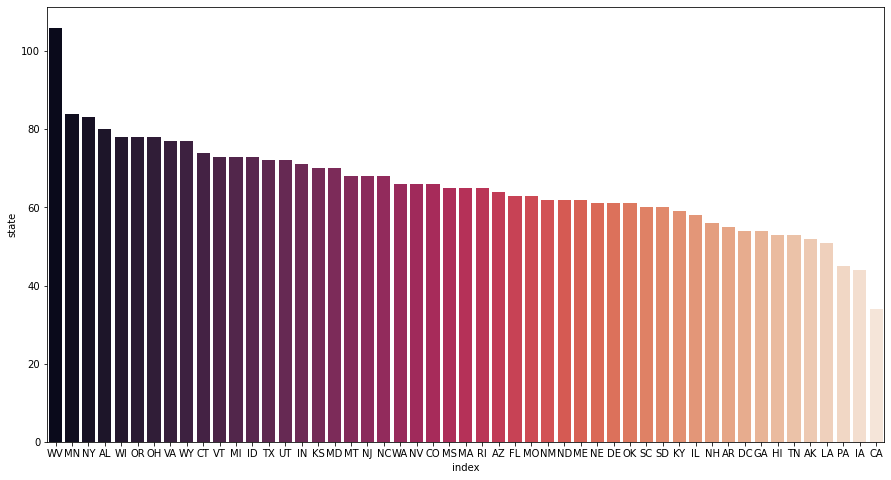

In [11]:
# contabilizando a frequência dos estados no dataset
state_count = pd.DataFrame(train.state.value_counts()).reset_index()

# plotando o resultado
plt.figure(figsize = (15, 8))
sns.barplot(data = state_count, x = 'index', y = 'state', palette = 'rocket')
plt.show()

O estado de **West Virgina** é o estado com maior número de clientes presente no dataset, enquanto o estado da **California** é  o que possui menos.

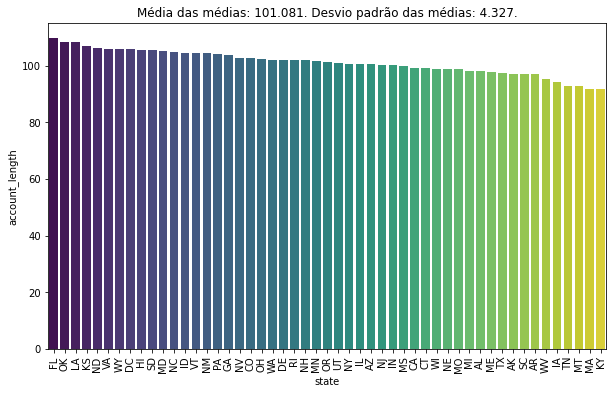

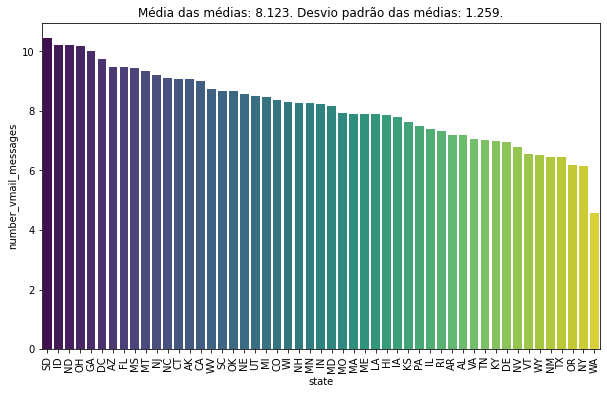

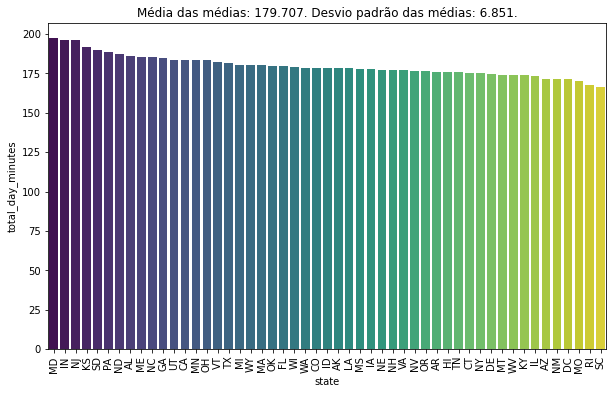

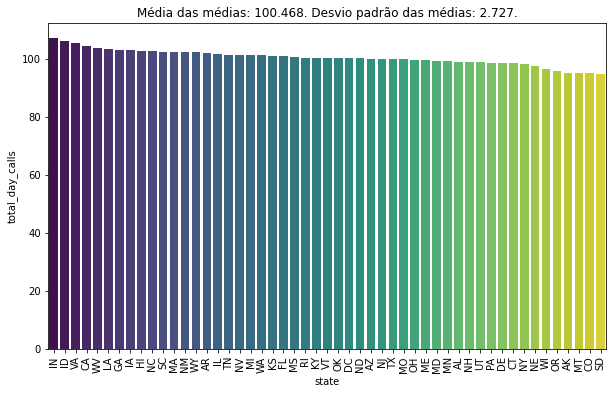

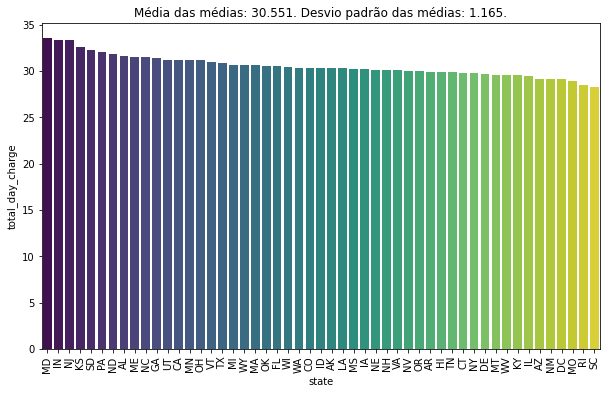

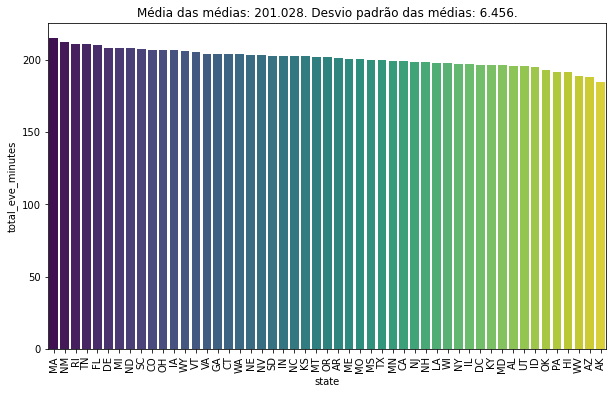

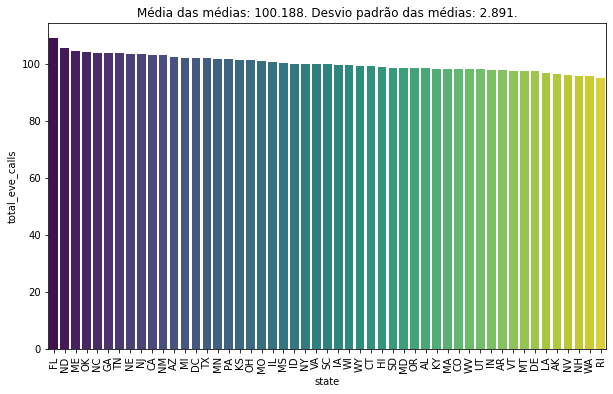

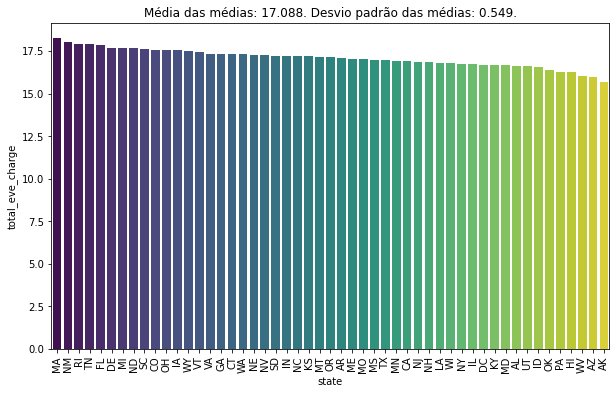

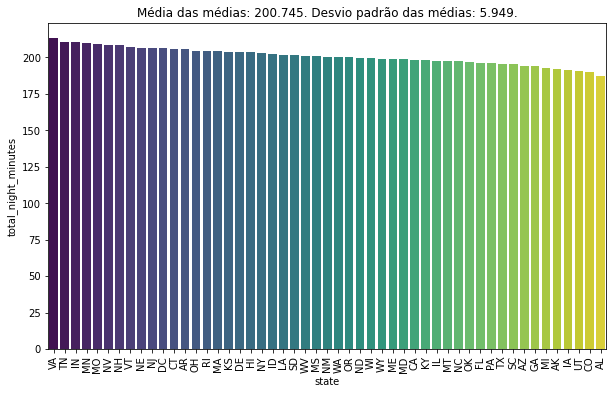

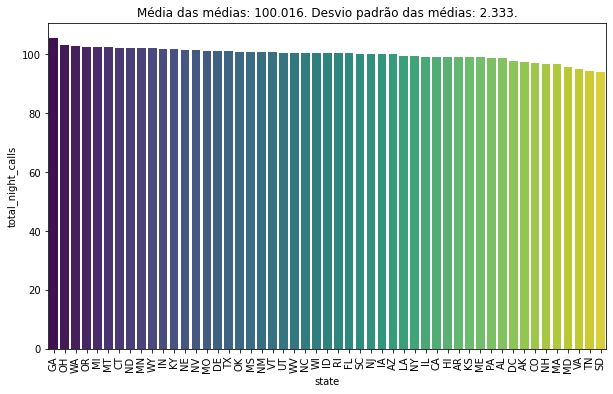

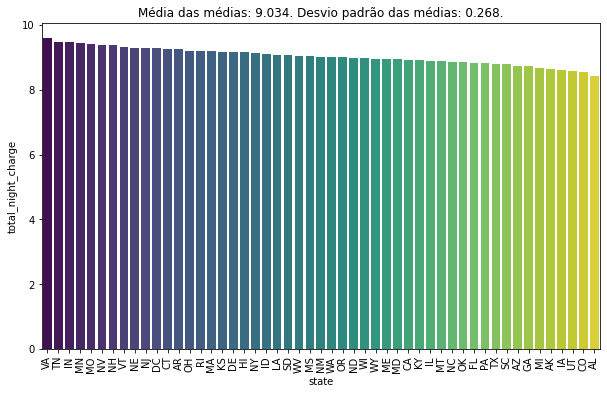

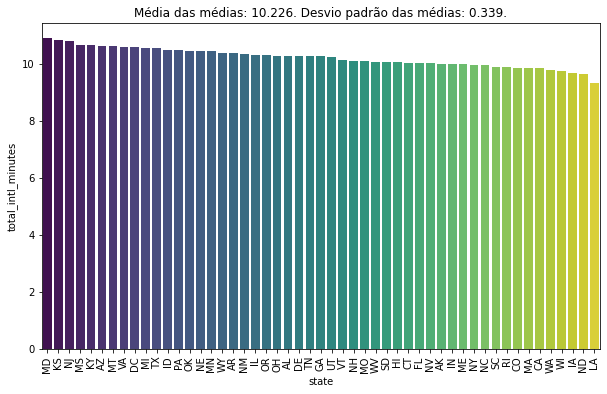

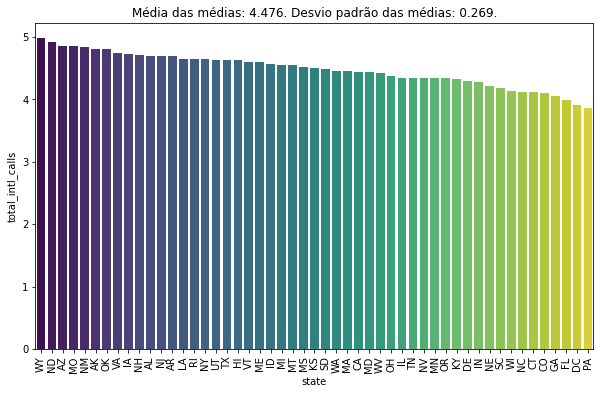

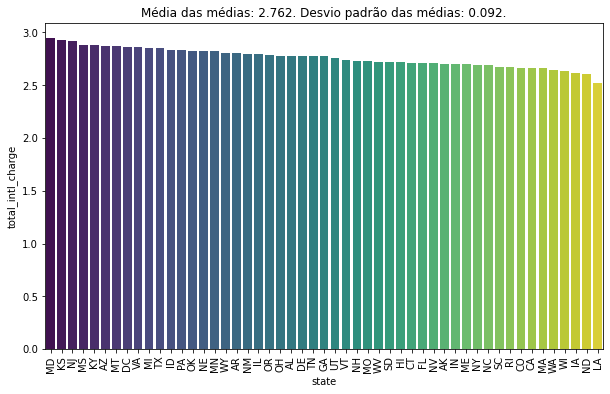

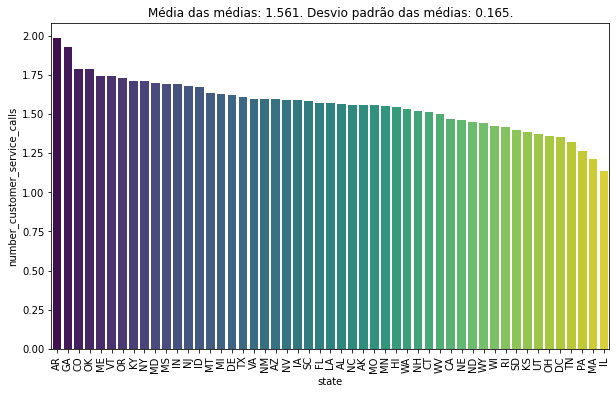

In [12]:
# extraindo o nome das colunas que possuem valores numéricos
num_cols = [col for col in train.columns if (train[col].dtype != 'object')]

# criando um dataframe
state_most_freq = pd.DataFrame()
state_less_freq = pd.DataFrame()

# loop para calcular a média por estado para todas as variáveis numéricas e gerando gráficos.
for col in num_cols:
    
    # dataframe com a média da coluna numperica por estado
    df         = train[['state', col]].groupby('state', as_index = False).mean().sort_values(col, ascending = False)
    mean       = round(df[col].mean(), 3)
    std        = round(df[col].std(),  3)
    
    # adicionando ao dataframe os 5 com maiores médias
    state_most_freq = state_most_freq.append(list(df.state.head().values))
    
    # adicionando ao dataframe os 5 com menores médias
    state_less_freq = state_less_freq.append(list(df.state.tail().values))
    
    # plotando o gráfico
    plt.figure(figsize = (10, 6))
    sns.barplot(x = 'state', y = col, data = df, palette = 'viridis')
    plt.title('Média das médias: {}. Desvio padrão das médias: {}.'.format(mean, std))
    plt.xticks(rotation = 90)
    plt.show()

# contabilizando a frequência dos estados que mais apareceram entre os cinco com maiores médias
state_most_freq = pd.DataFrame(state_most_freq[0].value_counts())
state_most_freq.columns = ['frequencia']

# contabilizando a frequência dos estados que menos apareceram entre os cinco com menores médias
state_less_freq = pd.DataFrame(state_less_freq[0].value_counts())
state_less_freq.columns = ['frequencia']

Os estados que apareceram mais vezes entre as cinco **maiores** médias:

* IN: Indiana
* KS: Kansas
* MD: Maryland
* FL: Florida
* TN: Tennessee

Os estados que apareceram mais vezes entre as cinco **menores** médias:

* AK: Alaska
* IA: Iowa
* DC: District of Columbia
* CO: Colorado
* WA: Washington

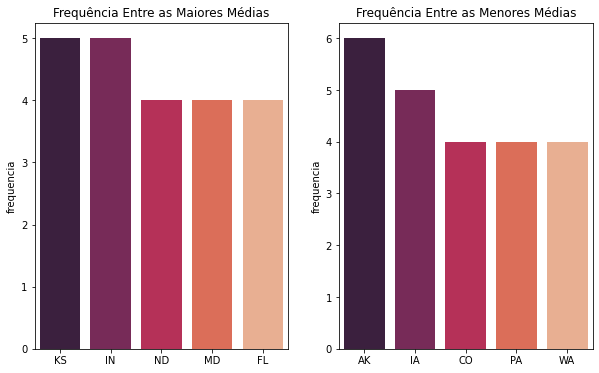

In [13]:
# gráfico com as frequências
plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 1)
sns.barplot(x = state_most_freq[0:5].index, y = 'frequencia', palette = 'rocket', data = state_most_freq[0:5])
plt.title('Frequência Entre as Maiores Médias')

plt.subplot(1, 2, 2)
sns.barplot(x = state_less_freq[0:5].index, y = 'frequencia', palette = 'rocket', data = state_less_freq[0:5])
plt.title('Frequência Entre as Menores Médias')

plt.show()

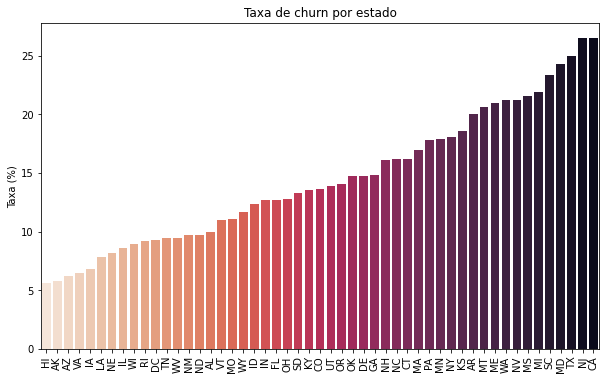

In [14]:
# calculando a taxa de churn
state_churn          = train[['state', 'churn']]
state_churn.churn    = state_churn.churn.apply(lambda x : 1 if x == 'yes' else 0)
state_churn.churn    = state_churn.churn.astype('int64')
state_churn['count'] = 1
state_churn          = state_churn.groupby('state', as_index = False).sum()
state_churn['taxa']  = round(100 * state_churn['churn'] / state_churn['count'], 2)
state_churn          = state_churn.sort_values('taxa').reset_index(drop = True)
state_churn

# plotando o gráfico
plt.figure(figsize = (10, 6))
sns.barplot(x = 'state', y = 'taxa', data = state_churn, palette = 'rocket_r')
plt.title('Taxa de churn por estado')
plt.xlabel('')
plt.ylabel('Taxa (%)')
plt.xticks(rotation = 90)
plt.show()

Os estados que possuem a **maior** taxa de perda de clientes são a California e New Jersey. Os que possuem as **menores** taxas são o Hawaii e o Alaska.

## 4.3 Código de Área

O código de área - também conhecido como código de registro - serve para identificar uma localidade ou um conjunto de localidades e deve ser usado para a realização de ligações de longa distância

Foi criado uma visualização para visualizar os códigos de área mais utilizados. 

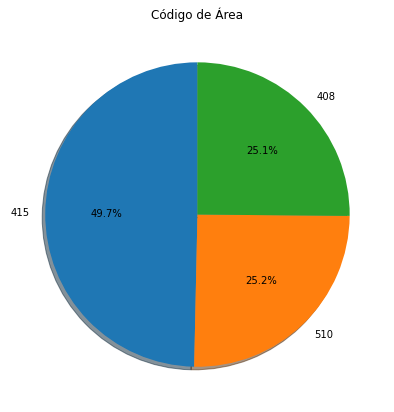

In [15]:
# dataset com as porcentagens
area_code               = pd.DataFrame(train.area_code.value_counts()).reset_index()
area_code.columns       = ['area_code', 'contagem']
area_code['percentage'] = round((100 * area_code.contagem / len(train)), 2)

# gráfico
plt.figure(figsize = (7, 7))
plt.pie(area_code.percentage, labels = area_code.area_code, autopct='%1.1f%%', shadow = True, startangle = 90)
plt.title('Código de Área')
plt.show()

O próximo gráfico mostra a relação de proporção entre a perda de clientes por código de área.

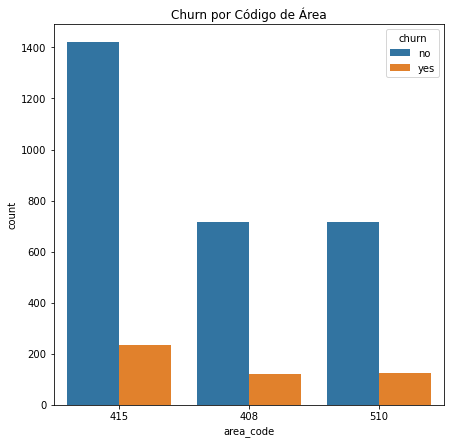

In [16]:
# churn por código de área
plt.figure(figsize = (7,7))
sns.countplot(x = "area_code", hue = "churn", data = train)
plt.title("Churn por Código de Área")
plt.show()

## 4.4 Serviços Contratados

De acordo com o dataset, são dois serviços adicionar que o cliente pode contratrar: plano internacional e plano de correio de voz. Vamos ver a proporção dos clientes que contratam esses serviços.

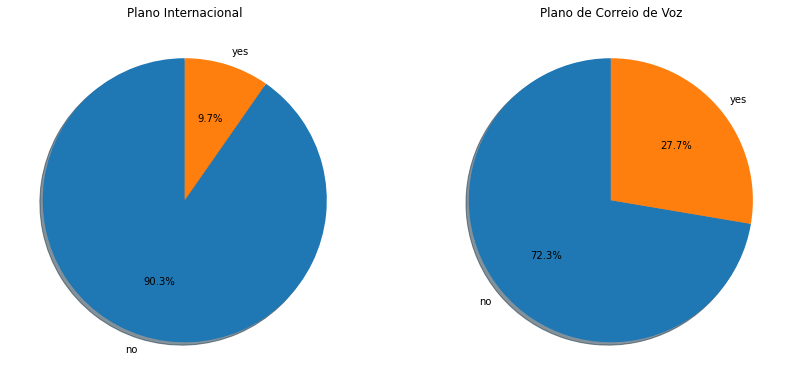

In [17]:
# dataset com as procentagens
int_plan                            = pd.DataFrame(train.international_plan.value_counts()).reset_index()
int_plan.columns                    = ['international_plan', 'contagem_int_plan']
int_plan['percentage_int_plan']     = round((100 * int_plan.contagem_int_plan / len(train)), 2)
voice_plan                          = pd.DataFrame(train.voice_mail_plan.value_counts()).reset_index()
voice_plan.columns                  = ['voice_mail_plan', 'contagem_voice_plan']
voice_plan['percentage_voice_plan'] = round((100 * voice_plan.contagem_voice_plan / len(train)), 2)
services                            = pd.concat([int_plan, voice_plan], axis = 1)


# gráfico
plt.figure(figsize = (14, 7))

plt.subplot(1, 2, 1)
plt.pie(services.percentage_int_plan, labels = services.international_plan, autopct='%1.1f%%', shadow = True, startangle = 90)
plt.title('Plano Internacional')

plt.subplot(1, 2, 2)
plt.pie(services.percentage_voice_plan, labels = services.voice_mail_plan, autopct='%1.1f%%', shadow = True, startangle = 90)
plt.title('Plano de Correio de Voz')

plt.show()

Os próximos gráficos apresentam a relação de proporção de churn com da contratação do serviço.

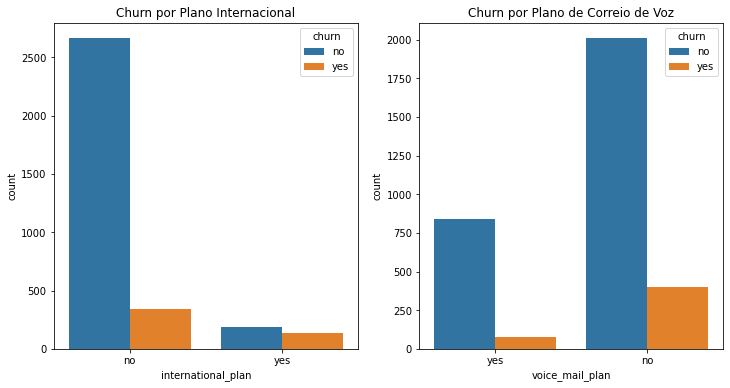

In [18]:
# churn por contrato de plano internacional
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x = 'international_plan', hue = 'churn', data = train)
plt.title('Churn por Plano Internacional')

plt.subplot(1, 2, 2)
sns.countplot(x = 'voice_mail_plan', hue = 'churn', data = train)
plt.title('Churn por Plano de Correio de Voz')

plt.show()

Parece haver uma correlação significativa entre a contratação do plano internacional e a saída do cliente da operadora.

## 4.5 Total de Minutos em Chamada

O dataset separa os minutos gastos por período do dia. A seguir vamos ver as principais estatísticas e visualizações para essas variáveis.

In [19]:
# estatísticas dos minutos em chamada por período do dia
cols_min = ['total_day_minutes', 'total_eve_minutes', 'total_night_minutes']
stats(cols_min)

,total_day_minutes,total_eve_minutes,total_night_minutes
count,3333.000000,3333.000000,3333.000000
mean,179.775098,200.980348,200.872037
std,54.467389,50.713844,50.573847
min,0.000000,0.000000,23.200000
25%,143.700000,166.600000,167.000000
50%,179.400000,201.400000,201.200000
75%,216.400000,235.300000,235.300000
max,350.800000,363.700000,395.000000


Em média é gasto menos tempo em chamadas pela manhã em comparação aos outros períodos do dia.

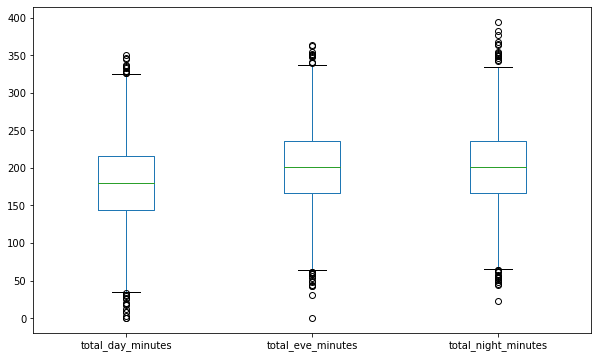

In [20]:
# boxplot dos minutos em chamada por período do dia
box(cols_min)

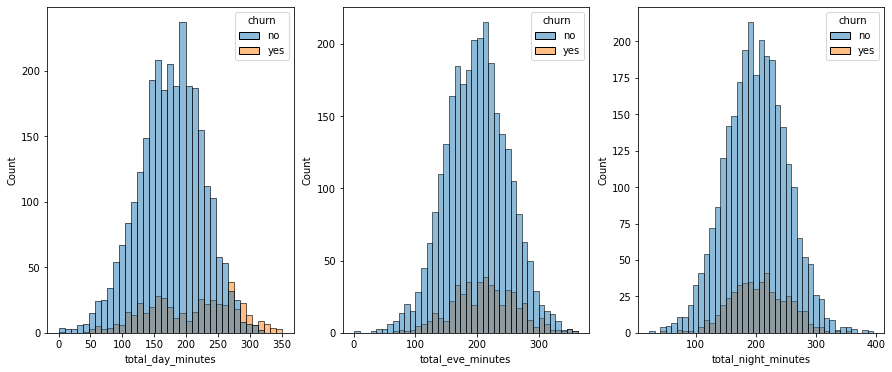

In [21]:
# plot histogram
histPlot(cols_min)

In [22]:
# estatísticas separadas
stats_churn(cols_min)

,total_day_minutes_churn_yes,total_day_minutes_churn_no,total_eve_minutes_churn_yes,total_eve_minutes_churn_no,total_night_minutes_churn_yes,total_night_minutes_churn_no
count,483.000000,2850.000000,483.000000,2850.000000,483.000000,2850.000000
mean,206.914079,175.175754,212.410145,199.043298,205.231677,200.133193
std,68.997792,50.181655,51.728910,50.292175,47.132825,51.105032
min,0.000000,0.000000,70.900000,0.000000,47.400000,23.200000
25%,153.250000,142.825000,177.100000,164.500000,171.250000,165.900000
50%,217.600000,177.200000,211.300000,199.600000,204.800000,200.250000
75%,265.950000,210.300000,249.450000,233.200000,239.850000,234.900000
max,350.800000,315.600000,363.700000,361.800000,354.900000,395.000000


As estatísticas sugerem que os clientes que saem da operadora são os que mais minutos gastam em média em chamadas.

## 4.6 Total de Chamadas

O dataset separa as ligações gastos por período do dia. A seguir vamos ver as principais estatísticas e visualizações para essas variáveis.

In [23]:
# estatísticas da quantidade de chamadas por período do dia
cols_calls = ['total_day_calls', 'total_eve_calls', 'total_night_calls']
stats(cols_calls)

,total_day_calls,total_eve_calls,total_night_calls
count,3333.000000,3333.000000,3333.000000
mean,100.435644,100.114311,100.107711
std,20.069084,19.922625,19.568609
min,0.000000,0.000000,33.000000
25%,87.000000,87.000000,87.000000
50%,101.000000,100.000000,100.000000
75%,114.000000,114.000000,113.000000
max,165.000000,170.000000,175.000000


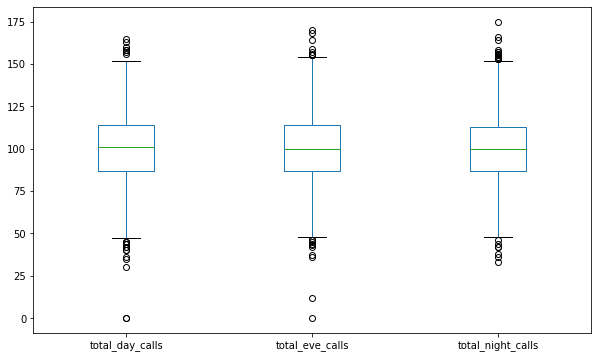

In [24]:
# boxplot da quantidade de chamadas por período do dia
box(cols_calls)

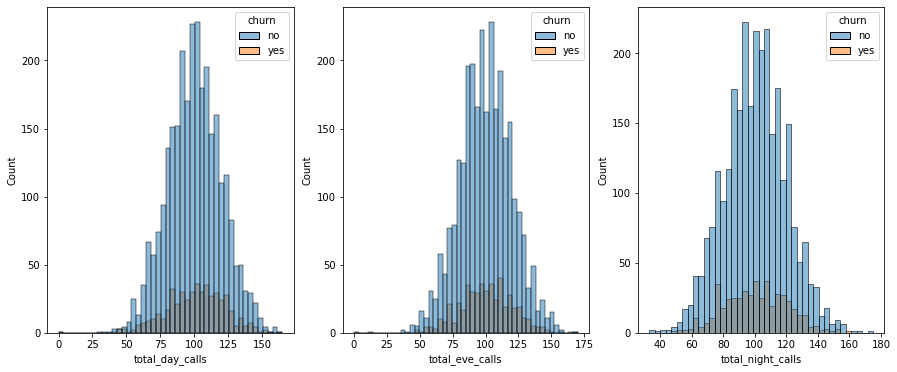

In [25]:
# plot histogram
histPlot(cols_calls)

In [26]:
# estatísticas separadas
stats_churn(cols_calls)

,total_day_calls_churn_yes,total_day_calls_churn_no,total_eve_calls_churn_yes,total_eve_calls_churn_no,total_night_calls_churn_yes,total_night_calls_churn_no
count,483.000000,2850.000000,483.000000,2850.000000,483.000000,2850.000000
mean,101.335404,100.283158,100.561077,100.038596,100.399586,100.058246
std,21.582307,19.801157,19.724711,19.958414,19.950659,19.506246
min,0.000000,0.000000,48.000000,0.000000,49.000000,33.000000
25%,87.500000,87.000000,87.000000,87.000000,85.000000,87.000000
50%,103.000000,100.000000,101.000000,100.000000,100.000000,100.000000
75%,116.500000,114.000000,114.000000,114.000000,115.000000,113.000000
max,165.000000,163.000000,168.000000,170.000000,158.000000,175.000000


## 4.7 Total de Recargas

O dataset separa as recargas feitas por período do dia. A seguir vamos ver as principais estatísticas e visualizações para essas variáveis.

In [27]:
# estatísticas das recargas
cols_charge = ['total_day_charge', 'total_eve_charge', 'total_night_charge']
stats(cols_charge)

,total_day_charge,total_eve_charge,total_night_charge
count,3333.000000,3333.000000,3333.000000
mean,30.562307,17.083540,9.039325
std,9.259435,4.310668,2.275873
min,0.000000,0.000000,1.040000
25%,24.430000,14.160000,7.520000
50%,30.500000,17.120000,9.050000
75%,36.790000,20.000000,10.590000
max,59.640000,30.910000,17.770000


As maiores recargas são feitas no período da manhã.

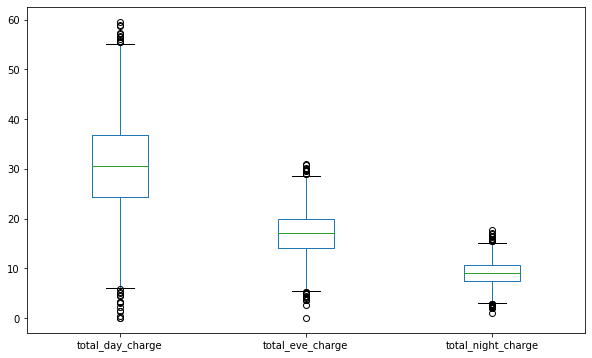

In [28]:
# boxplot das recargas
box(cols_charge)

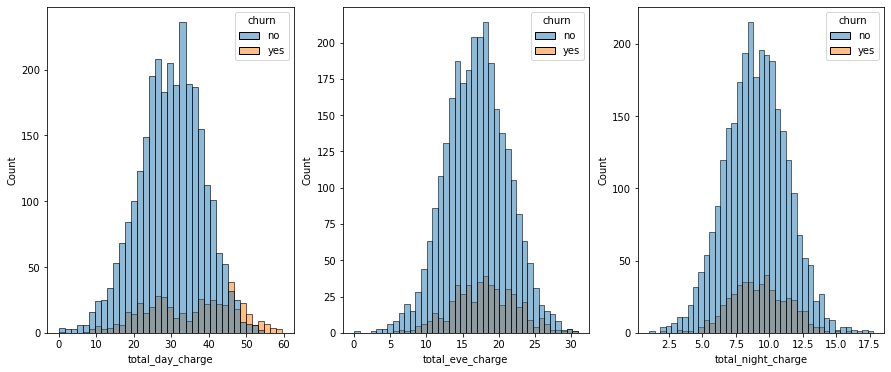

In [29]:
# plot dos histogramas
histPlot(cols_charge)

In [30]:
# estatísticas separadas por churn
stats_churn(cols_charge)

,total_day_charge_churn_yes,total_day_charge_churn_no,total_eve_charge_churn_yes,total_eve_charge_churn_no,total_night_charge_churn_yes,total_night_charge_churn_no
count,483.000000,2850.000000,483.000000,2850.000000,483.000000,2850.000000
mean,35.175921,29.780421,18.054969,16.918909,9.235528,9.006074
std,11.729710,8.530835,4.396762,4.274863,2.121081,2.299768
min,0.000000,0.000000,6.030000,0.000000,2.130000,1.040000
25%,26.055000,24.282500,15.055000,13.980000,7.705000,7.470000
50%,36.990000,30.120000,17.960000,16.970000,9.220000,9.010000
75%,45.210000,35.750000,21.205000,19.820000,10.795000,10.570000
max,59.640000,53.650000,30.910000,30.750000,15.970000,17.770000


## 4.8 Churn

Vamos verificar a proporção do dataset sobre a variável target (churn).

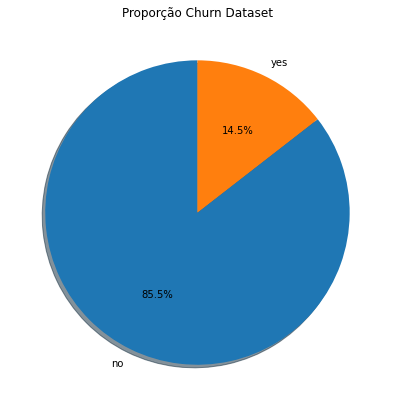

In [31]:
churn_perc = pd.DataFrame(train['churn'].value_counts()).reset_index()
churn_perc.columns = ['churn', 'total']
churn_perc['percentage'] = round(  (100 * churn_perc.total / churn_perc.total.sum())  , 3)
churn_perc

plt.figure(figsize = (7, 7))
plt.pie(churn_perc.percentage, labels = churn_perc.churn, autopct='%1.1f%%', shadow = True, startangle = 90)
plt.title('Proporção Churn Dataset')
plt.show()

O churn rate para esse dataset é de **14.5%**.

## 4.9 Correlações

Vamos analisar as correlações de Pearson, que mede o grau de relacionamento (e a direção dessa correlação - se positiva ou negativa) entre duas variáveis.

### 4.9.1 Transformando os Dados

Antes de analisarmos as correlações, vamos transformar as variáveis que possuem valores como "object" em valores numéricos.

In [32]:
# criando uma cópia do dataset
train_trans = train.copy()
test_trans  = test.copy()

# lista com as variáveis a serem transformados
col_cat = ['state', 'international_plan', 'voice_mail_plan', 'churn']

# transformação
for col in col_cat:
    train_trans[col] = train_trans[col].astype('category').cat.codes
    test_trans[col]  = test_trans[col].astype('category').cat.codes

In [33]:
# resultado no dataset de treino
train_trans.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [34]:
# resultado no dataset de teste
test_trans.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,11,101,510,0,0,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,0
1,26,137,510,0,0,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,0
2,35,103,408,0,1,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,0
3,32,99,415,0,0,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,0
4,40,108,415,0,0,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,0


### 4.9.2 Correlações

In [35]:
# gerando matrix com as correlações
train_corr = train_trans.corr()
train_corr

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
state,1.000000,0.003678,-0.004597,-0.031664,-0.027762,-0.006737,-0.000764,-0.006736,0.013682,-0.016268,0.013674,0.024576,0.007458,0.024572,-0.007834,0.013967,-0.007819,-0.025861,0.007780
account_length,0.003678,1.000000,0.024735,0.002918,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
international_plan,-0.004597,0.024735,1.000000,0.006006,0.008745,0.049396,0.003755,0.049398,0.019100,0.006114,0.019106,-0.028905,0.012451,-0.028913,0.045871,0.017366,0.045780,-0.024522,0.259852
voice_mail_plan,-0.031664,0.002918,0.006006,1.000000,0.956927,-0.001684,-0.011086,-0.001686,0.021545,-0.006444,0.021559,0.006079,0.015553,0.006064,-0.001318,0.007618,-0.001276,-0.017824,-0.102148
number_vmail_messages,-0.027762,-0.004628,0.008745,0.956927,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
total_day_minutes,-0.006737,0.006216,0.049396,-0.001684,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.205151
total_day_calls,-0.000764,0.038470,0.003755,-0.011086,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
total_day_charge,-0.006736,0.006214,0.049398,-0.001686,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
total_eve_minutes,0.013682,-0.006757,0.019100,0.021545,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.092796
total_eve_calls,-0.016268,0.019260,0.006114,-0.006444,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233


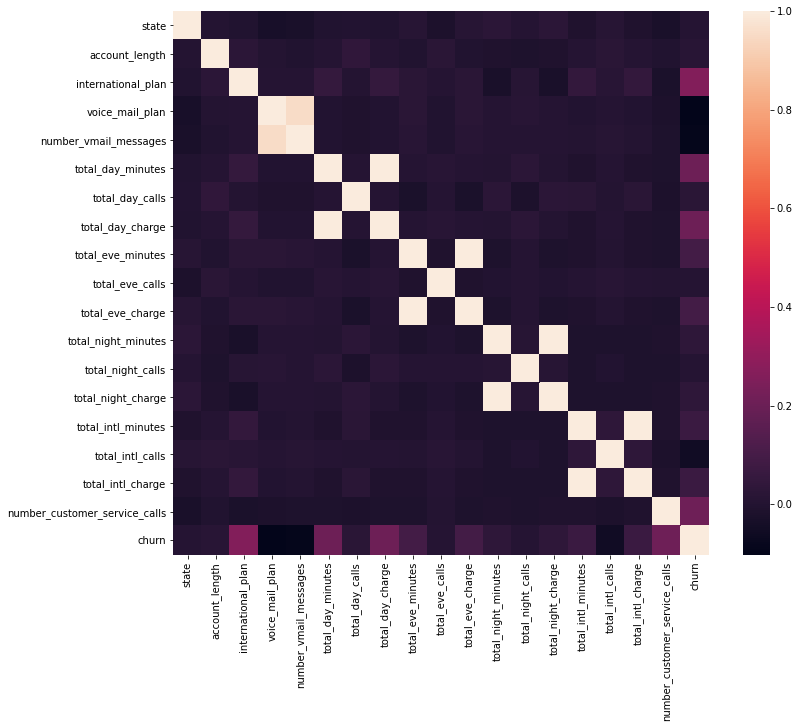

In [36]:
# imprimindo visualmente o resultado
plt.figure(figsize = (12, 10))
sns.heatmap(train_corr)
plt.show()

Existe uma correlação perfeitamente positiva entre o total de minutos gasto por período e recarga para aquele mesmo período.

# 5.0 Features Extraction

Como visto no item anterior, existem em nosso dataset variáveis colineares, isso significa que, essas variáveis possuem relações lineares exatas ou aproximadamente exatas.

Pontanto, uma das variáveis que possuirem correlação superior a |0.95| será eliminada. Isso é feito pois são variáveis que apresentaram a mesma informação para o modelo posteriormente.

In [37]:
# pegando a porção superior da matrix de correlação
train_corr        = train_corr.where(np.triu(np.ones(train_corr.shape), k = 1).astype('bool'))

# selecionando as variáveis que possuem correlação superior a 0.95
colinear_features = [col for col in train_corr.columns if any(train_corr[col] > 0.95)]

# eliminando essas variáveis dos datasets
train_trans = train_trans.drop(colinear_features, axis = 1)
test_trans  = test_trans.drop(colinear_features,  axis = 1)
print(train_trans.shape, test_trans.shape)

(3333, 15) (1667, 15)


O dataset possuia **20 colunas**, com a eliminação das variáveis colineares o dataset passa a possuir **15 colunas**.

# 6.0 Feature Selection

A feature selection (seleção de variáveis) é o processo de selecionar um subconjunto de variáveis relevantes para uso na construção de modelo. As técnicas de seleção de recursos são usadas por vários motivos:

* Simplificação dos modelos para torná-los mais fáceis de serem interpretados

* Menor tempo de treinamento

* Evitar a maldição da dimensionalidade

* Tornar o modelo o mais generalizável possível, evitando o overfitting

* De múltiplas explicações adequadas e possíveis para o mesmo conjunto de fatos, deve-se optar pela mais simples daquelas (princípio de Occam's Razor)

Para essa seleção, será utilizado as pontuações de importância que o algoritmo Random Forest atribui as variáveis.

In [38]:
# separando o dataset em variáveis preditoras e variável target
x = train_trans.iloc[:, :14]
y = train_trans.churn

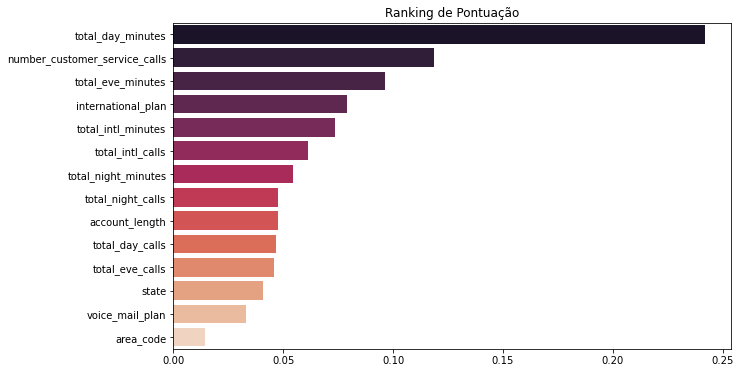

In [39]:
# contruindo o modelo
modelo_rf = RandomForestClassifier()

# treinando o modelo
modelo_rf.fit(x, y)

# extraindo a pontuação de cada feature e montando um dataframe com os resultados
features_rf = pd.DataFrame({'features'   : x.columns,
                            'pontuation' : modelo_rf.feature_importances_}).sort_values('pontuation', ascending = False).reset_index(drop = True)

# plotando os resultados
plt.figure(figsize = (10,6))
sns.barplot(y = 'features', x = 'pontuation', data = features_rf, palette = 'rocket', orient = 'h')
plt.title('Ranking de Pontuação')
plt.ylabel('')
plt.xlabel('')
plt.show()

A seguir será realizado vários treinamentos do modelo, e para cada treinamento será utilizado um subconjunto de variáveis de acordo com o ranking de pontuação obtido na célula logo atrás. 

O primeiro treinamento utilizará apenas a variável mais bem colocada, o segundo treinamento usará as duas variáveis mais bem colocadas, o terceiro usará as três variáveis mais bem colocadas, e assim por diante.

Esse processo será realizado para determinar o melhor conjunto de variáveis para a construção dos modelos posteriormente.

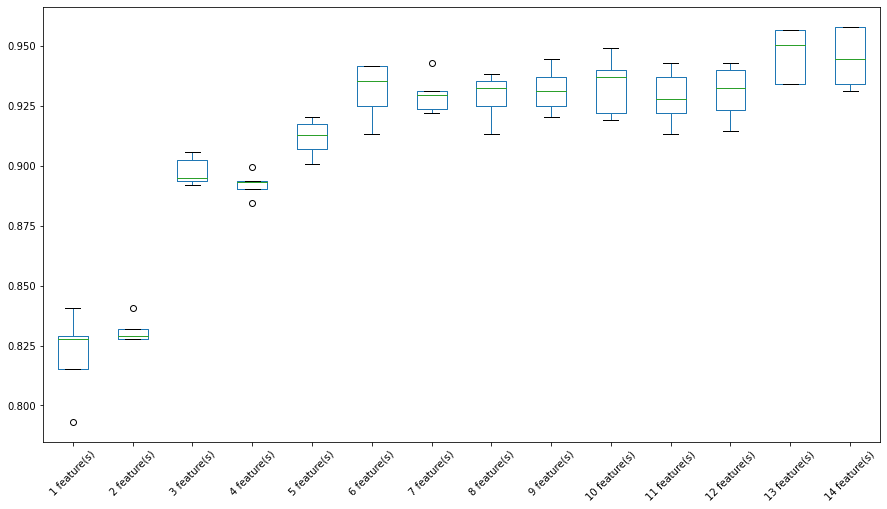

In [40]:
# lista vazia para adicionar os nomes das colunas
cols   = []

# dataframe para adicionar os resultados dos treinamentos
result = pd.DataFrame()

# loop for para realizar os treinamentos e salvar os resultados
for col in features_rf.features:
    cols.append(col)
    
    modelo = RandomForestClassifier(random_state = 0)
    modelo.fit(x[cols], y)
    
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)
        
    acc = cross_val_score(modelo, x[cols], y, cv = kfold, scoring = 'accuracy')
    
    result[str(len(cols)) + ' feature(s)'] = acc

# boxplot com os resultados
result.plot(kind = 'box', figsize = (15,8))
plt.xticks(rotation = 45)
plt.show()

O subconjunto com **13 features** apresentou a maior acurácia entre todos os subconjuntos, porém o subconjunto com **14 features** apresentou a maior média de acurária entre todos.

# 7.0 Construção do Modelo Preditivo

Nessa estapa, o modelo será treinado, para que, seja possível prever se um cliente vai ou não deixar a operadora. Para isso, será utilizado vários algoritmos de classificação, sendo possível assim, escolher o melhor entre todos.

O modelo que apresentar maior acurácia com os dados de treino receberá uma otimização, objetivando o maior acréscimo para essa métrica.

## 7.1 Algoritmos

In [41]:
# lista com os modelos utilizados
models = []

models.append(('RF',  RandomForestClassifier()))
models.append(('LR',  LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB',  GaussianNB()))
models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))

## 7.2 Treinamento

O treinamento será realizado com os dados sem transformação, com os dados normalizados (MinMaxScaler e Normalizer) e com os dados padronizados (StandardScaler).

### 7.2.1 Com Dados sem Transformação

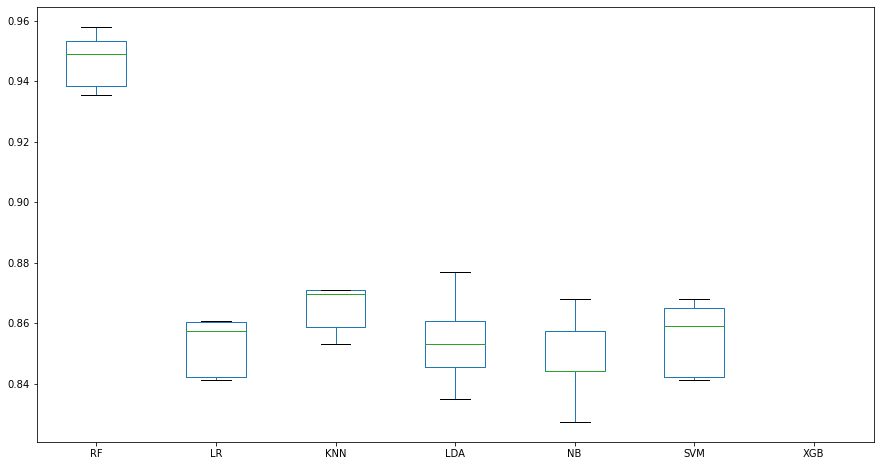

,RF,LR,KNN,LDA,NB,SVM,XGB
mean,94.68900,85.23800,86.46900,85.41900,84.81800,85.5080,NaN
std,0.00863,0.00879,0.00737,0.01418,0.01374,0.0113,NaN


In [42]:
fitting(models, x, y)

* O **Random Forest** apresentou a melhor performance entre todos.

* O **KNN** apresentou a menor variação de acurácia em relação a média.

* O **XGboost** não apresentou nenhum resultado pois o mesmo esperava os dados de uma forma diferente da que foi apresentado a ele.

### 7.2.2 Dados com Normalização (MinMaxScaler)

Essa normalização coloca os valores de cada coluna em uma escala que vai de 0 a 1.

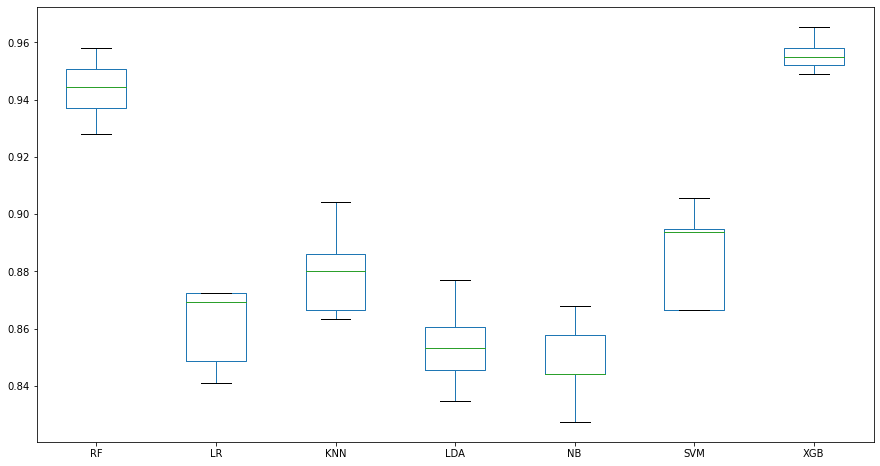

,RF,LR,KNN,LDA,NB,SVM,XGB
mean,94.36000,86.0780,87.99800,85.41900,84.81800,88.539,95.59000
std,0.01041,0.0134,0.01463,0.01418,0.01374,0.016,0.00565


In [43]:
fitting(models, min_max_scaler(x), y)

* O **XGboost** apresentou a maior acurácia média e o menor desvio em relação a sua média.

* Os resultados foram superior aos resultados obtidos com os dados sem transformação.

### 7.2.3 Dados com Normalização (Normalizer)

Essa normalização coloca todos os valores de todas as colunas em uma escala de 0 a 1.

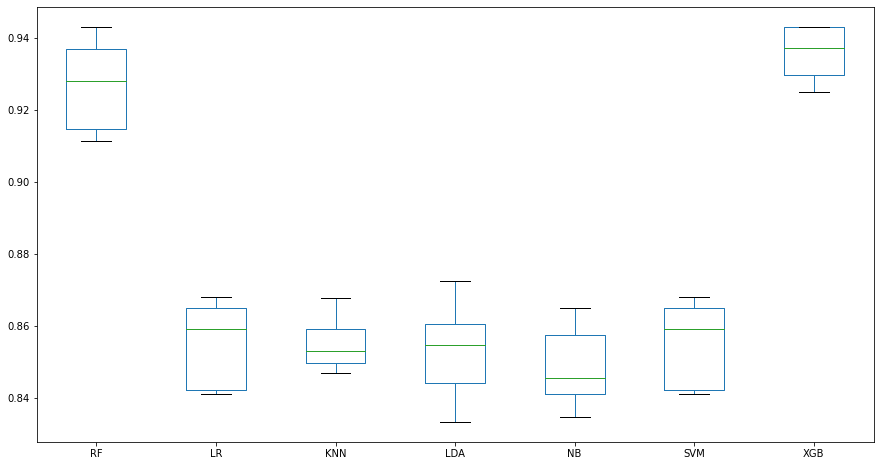

,RF,LR,KNN,LDA,NB,SVM,XGB
mean,92.67900,85.5080,85.53900,85.29900,84.87900,85.5080,93.54900
std,0.01229,0.0113,0.00741,0.01343,0.01095,0.0113,0.00724


In [44]:
fitting(models, normalizer(x), y)

* O **XGboost** apresentou a maior acurácia média e o menor desvio em relação a sua média.

* Os resultados obtidos com a normalização de todo o dataset é inferior aos resultados obtidos com a normalização por variável.

### 7.2.4 Dados Padronizados (StandardScaler)

Essa padronização aproxima os valores de cada coluna para uma distribuição normal, isto é, com média igual a 0. Os valores são transformados em uma escala de -1 a 1.

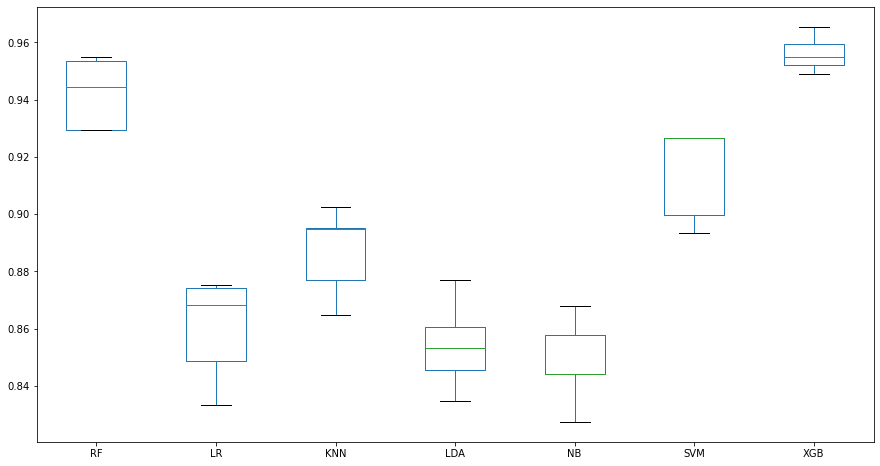

,RF,LR,KNN,LDA,NB,SVM,XGB
mean,94.23900,85.98800,88.68800,85.41900,84.81800,91.44900,95.62000
std,0.01113,0.01638,0.01384,0.01418,0.01374,0.01484,0.00579


In [45]:
fitting(models, standard_scaler(x), y)

* O **XGboost** apresentou a maior acurácia média e o menor desvio em relação a sua média.

* **Logistic Regression** e **SVM** obtiveram melhores resultados com os dados padronizados em relação aos outros tipos de normalização.

### 7.5 Otimização do Modelo

Por ter obtido a maior acurácia com os dados de treino, irei utilizar o algoritmo XGBoost para realizar o ajuste fino.

In [46]:
# parâmetros serem utilizados no treinamento
hyper_xgb = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
             "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
             "min_child_weight" : [1, 3, 5, 7],
             "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
             "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7]}

# modelo
model = XGBClassifier()

# otmizador
tuning = RandomizedSearchCV(estimator = model, param_distributions = hyper_xgb,
                            cv = 10, verbose = True, n_jobs = -1, scoring = 'accuracy',
                            random_state = 0)

# treinamento
tuning.fit(standard_scaler(x), y)

# melhores parâmetros
tuned_model = tuning.best_estimator_

# treinando o modelo para posteriormente fazer as previsões com os dados de teste
tuned_model.fit(standard_scaler(x), y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# 8.0 Previsões Para os Dados de Teste

Agora, o modelo otimizado será submetido a realizar previsões com os dados de teste.

## 8.1 Dados

In [47]:
# separando os dados em variáveis preditoras e variável target.
# padronizando os valores.
x_test = standard_scaler(test_trans.iloc[:, 0:14])
y_test = test_trans.churn

## 8.2 Previsões

In [48]:
# fazendo as previsões com os dados de teste
predictions = tuned_model.predict(x_test)


# calculando a probabilidade do cliente sair da operadora
prob_churn  = tuned_model.predict_proba(x_test)
probability = pd.DataFrame(100 * prob_churn)[1]

# criando um dataframe com as variáveis preditoras, as previsões e as probabilidades.
predictions_df = pd.DataFrame({'Predictions' : predictions,
                               'Probability' : probability})

predictions_df = pd.concat([test_trans.iloc[:, :14], predictions_df], axis = 1)

# imprimindo o dataset
predictions_df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,Predictions,Probability
0,11,101,510,0,0,70.9,123,211.9,73,236.0,73,10.6,3,3,0,2.954413
1,26,137,510,0,0,223.6,86,244.8,139,94.2,81,9.5,7,0,0,3.529191
2,35,103,408,0,1,294.7,95,237.3,105,300.3,127,13.7,6,1,1,61.867310
3,32,99,415,0,0,216.8,123,126.4,88,220.6,82,15.7,2,1,0,3.474869
4,40,108,415,0,0,197.4,78,124.0,101,204.5,107,7.7,4,2,0,0.888293


A seguir plot com o churn rate previsto com os dados de teste.

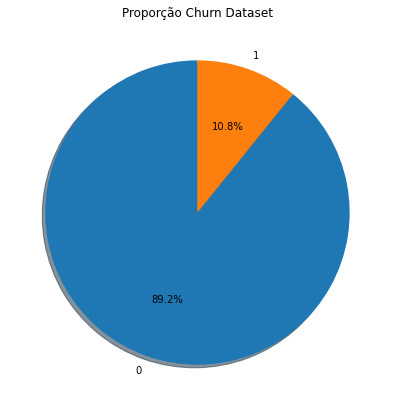

In [49]:
# dataset com as taxas
churn_pred = pd.DataFrame(predictions_df['Predictions'].value_counts()).reset_index()
churn_pred.columns = ['churn', 'total']
churn_pred['percentage'] = round(  (100 * churn_pred.total / churn_pred.total.sum())  , 3)
churn_pred

# piechart
plt.figure(figsize = (7, 7))
plt.pie(churn_pred.percentage, labels = churn_pred.churn, autopct='%1.1f%%', shadow = True, startangle = 90)
plt.title('Proporção Churn Dataset')
plt.show()

O **churn rate** previsto é de 10.8%.

## 8.3 Avaliação

A acurácia para os dados de teste é de 95.32%. 



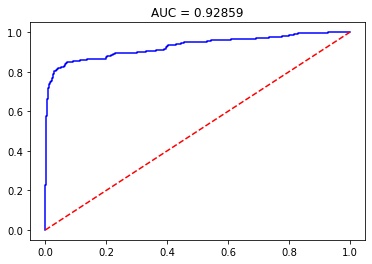

Relatório de classificação: 

               precision    recall  f1-score   support

           0       0.96      0.99      0.97      1443
           1       0.91      0.73      0.81       224

    accuracy                           0.95      1667
   macro avg       0.93      0.86      0.89      1667
weighted avg       0.95      0.95      0.95      1667



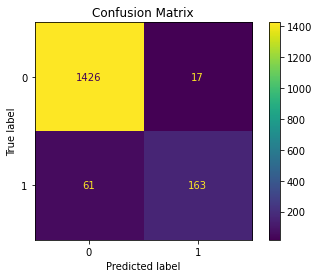

In [50]:
# acurácia do modelo
print('A acurácia para os dados de teste é de {}%. \n'.format(round(100 * tuned_model.score(x_test, y_test), 2)))

# roc auc curve
fpr, tpr, _ = roc_curve(y_test, prob_churn[:, 1])
roc_auc     = round(auc(fpr, tpr), 5)
    
# plot da auc
plt.title('AUC = {}'.format(roc_auc))
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.show()

# classification report
print('Relatório de classificação: \n\n', classification_report(y_test, predictions))

# confusion matrix
plot_confusion_matrix(tuned_model, x_test, y_test)
plt.title('Confusion Matrix')
plt.show()